In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression



In [ ]:
phiusiil_phishing_url_website = fetch_ucirepo(id=967)
X_full = phiusiil_phishing_url_website.data.features.copy()
y_full = phiusiil_phishing_url_website.data.targets.copy()
target_col = y_full.columns[0]
df = pd.concat([X_full, y_full], axis=1)

drop_cols = [target_col]
for col in ["FILENAME", "FileName", "file_name"]:
    if col in df.columns:
        drop_cols.append(col)

X_full = df.drop(columns=drop_cols)
y_full = df[target_col]




In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

train_numeric = X_train.select_dtypes(include=["int64", "float64"])
corr_with_target = train_numeric.corrwith(y_train.squeeze()).abs()
threshold = 0.05
selected_numeric_features = corr_with_target[corr_with_target >= threshold].index.tolist()

train_categorical_features = X_train.select_dtypes(include=["object", "bool"]).columns.tolist()

X_train = X_train[selected_numeric_features + train_categorical_features]
X_test = X_test[selected_numeric_features + train_categorical_features]

numeric_selected_train = X_train[selected_numeric_features]




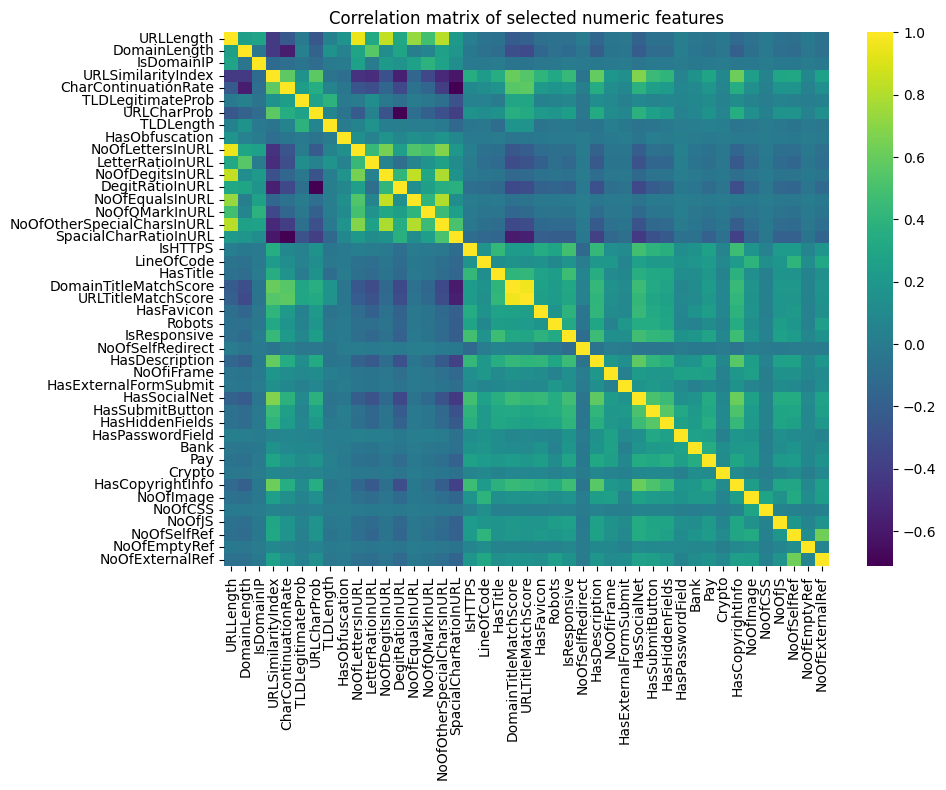

In [5]:
plt.figure(figsize=(10, 8))
sns.heatmap(train_numeric[selected_numeric_features].corr(), cmap="viridis")
plt.title("Correlation matrix of selected numeric features")
plt.tight_layout()
plt.show()

In [6]:
numeric_features = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X_train.select_dtypes(include=["object", "bool"]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


In [7]:
models = {
    "knn": KNeighborsClassifier()
}
param_grids = {
    "knn": {
        "clf__n_neighbors": [3, 5, 11],
        "clf__weights": ["uniform", "distance"],
        "clf__metric": ["minkowski", "manhattan"]
    }
}
best_models = {}
results = []

In [8]:
for name, model in models.items():
    pipe = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("clf", model)
    ])
    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grids[name],
        cv=3,
        scoring="f1",
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_
    y_pred = grid.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    results.append({
        "model": name,
        "best_params": grid.best_params_,
        "test_accuracy": acc,
        "test_precision": prec,
        "test_recall": rec,
        "test_f1": f1
    })

results_df = pd.DataFrame(results)
print(results_df)


Fitting 3 folds for each of 12 candidates, totalling 36 fits


KeyboardInterrupt: 

In [ ]:
def plot_confusion_matrix(cm, classes, title):
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=classes, yticklabels=classes)
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.title(title)
    plt.tight_layout()
    plt.show()

for name, model in best_models.items():
    y_pred = model.predict(X_test)
    print(name.upper())
    print(classification_report(y_test, y_pred, digits=4))
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(
        cm,
        ["phishing (0)", "legitimate (1)"],
        f"{name.upper()} - Confusion Matrix"
    )

metrics_to_plot = ["test_accuracy", "test_precision", "test_recall", "test_f1"]

plt.figure(figsize=(8, 5))
for metric in metrics_to_plot:
    plt.plot(
        results_df["model"],
        results_df[metric],
        marker="o",
        label=metric.replace("test_", "").capitalize()
    )


In [ ]:

plt.ylim(0.5, 1.0)
plt.title("Model Comparison on Test Set")
plt.xlabel("Model")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()

results_df.sort_values("test_f1", ascending=False)

Logistic Regression


In [12]:
# Build a pipeline for Logistic Regression
logreg_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("clf", LogisticRegression(max_iter=1000))
])
# Hyperparameter grid for Logistic Regression
logreg_param_grid = {
    "clf__C": [0.01, 0.1, 1.0, 10.0],
    "clf__penalty": ["l2"],
    "clf__class_weight": [None, "balanced"],
    "clf__solver": ["lbfgs"],  # works with L2
}

logreg_grid = GridSearchCV(
    estimator=logreg_pipeline,
    param_grid=logreg_param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)

logreg_grid.fit(X_train, y_train)

print("Best params (Logistic Regression):")
print(logreg_grid.best_params_)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best params (Logistic Regression):
{'clf__C': 10.0, 'clf__class_weight': 'balanced', 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}


In [13]:
# Best Logistic Regression pipeline
best_logreg = logreg_grid.best_estimator_

# Predict on test set
y_pred_logreg = best_logreg.predict(X_test)

# Basic metrics
logreg_acc = accuracy_score(y_test, y_pred_logreg)
logreg_prec = precision_score(y_test, y_pred_logreg)
logreg_rec = recall_score(y_test, y_pred_logreg)
logreg_f1 = f1_score(y_test, y_pred_logreg)

print("Logistic Regression – Test Set Performance")
print(f"Accuracy : {logreg_acc:.4f}")
print(f"Precision: {logreg_prec:.4f}")
print(f"Recall   : {logreg_rec:.4f}")
print(f"F1-score : {logreg_f1:.4f}\n")

print("Classification report (Logistic Regression):")
print(classification_report(y_test, y_pred_logreg, digits=4))


Logistic Regression – Test Set Performance
Accuracy : 0.9999
Precision: 0.9998
Recall   : 1.0000
F1-score : 0.9999

Classification report (Logistic Regression):
              precision    recall  f1-score   support

           0     1.0000    0.9998    0.9999     20189
           1     0.9998    1.0000    0.9999     26970

    accuracy                         0.9999     47159
   macro avg     0.9999    0.9999    0.9999     47159
weighted avg     0.9999    0.9999    0.9999     47159



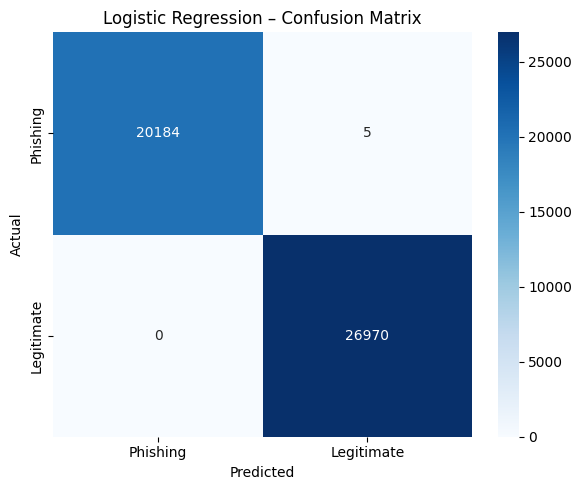

In [22]:
# Confusion matrix
cm_logreg = confusion_matrix(y_test, y_pred_logreg)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_logreg,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Phishing", "Legitimate"],
    yticklabels=["Phishing", "Legitimate"]
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Logistic Regression – Confusion Matrix")
plt.tight_layout()
plt.show()


In [23]:
# Extract fitted parts from the best pipeline
logreg_clf = best_logreg.named_steps["clf"]
preprocessor_fitted = best_logreg.named_steps["preprocessor"]

# Get feature names after preprocessing (numeric + one-hot)
feature_names = preprocessor_fitted.get_feature_names_out()

# Coefficients for the positive class (Legitimate)
coefs = logreg_clf.coef_[0]

# Top features pushing towards positive class (Legitimate)
top_pos_idx = np.argsort(coefs)[-10:][::-1]
# Top features pushing towards class 0
top_neg_idx = np.argsort(coefs)[:10]

top_positive = pd.DataFrame({
    "feature": feature_names[top_pos_idx],
    "coefficient": coefs[top_pos_idx]
})

top_negative = pd.DataFrame({
    "feature": feature_names[top_neg_idx],
    "coefficient": coefs[top_neg_idx]
})

print("Top features pushing prediction towards positive class (Legitimate):")
display(top_positive)

print("\nTop features pushing prediction towards negative class (Phishing):")
display(top_negative)

Top features pushing prediction towards positive class (Legitimate):


,feature,coefficient
0,num__URLSimilarityIndex,7.653137
1,num__IsHTTPS,3.902525
2,num__DomainLength,2.157170
3,num__NoOfSelfRef,1.836817
4,num__NoOfJS,1.631652
5,num__NoOfExternalRef,1.574296
6,num__HasSocialNet,1.550824
7,num__NoOfImage,1.432245
8,num__HasTitle,1.079869
9,num__LineOfCode,0.934377



Top features pushing prediction towards negative class (Phishing):


,feature,coefficient
0,num__LetterRatioInURL,-2.762790
1,num__SpacialCharRatioInURL,-1.952454
2,num__DegitRatioInURL,-1.608795
3,num__CharContinuationRate,-0.895735
4,cat__TLD_com,-0.408949
5,num__NoOfOtherSpecialCharsInURL,-0.404243
6,cat__Title_0,-0.401423
7,num__URLTitleMatchScore,-0.370982
8,num__TLDLegitimateProb,-0.365548
9,num__HasExternalFormSubmit,-0.311431
